#### Bayesian optimization through random Fourier features

We replace virtual samples obtained using eigendecomposition with random Fourier features, and see how the simple optimization goes

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time

plt.style.use('dark_background')
np.set_printoptions(formatter={'float': '{: 0.2e}'.format})

In [ ]:
class BayesianKernelRegression:
    def __init__(
        self,
        num_points=30,
        num_x_test=200,
        num_rff_features=100,
        num_mc=10,
        metropolis_step_size=1e-4,
        num_samples_metropolis=300,
        burn_in=100,
        num_gd_iter= 10000,
        debug=False,
        random_seed=42,
        lcb_k=1.0
        ):
        np.random.seed(random_seed)

        self.debug = debug # Toggle printing stuff
        self.num_features = num_rff_features  # Number of random Fourier features

        # Initialize parameters as class attributes
        self.num_points = num_points # Original data points
        self.num_x_test = num_x_test # Number of x_test
        self.sigma_d_true = 0.2 # True standard deviation of noise in measured y, only used in generating data
        self.sigma_d = 0.1 # Guessed standard deviation of noise in measured y, only used in model
        self.sigma_k = 2 # Kernel
        self.sigma_theta = 0.5 # Prior of theta
        self.learning_rate = 0.00001
        self.iterations = num_gd_iter
        self.num_samples_metropolis = num_samples_metropolis # For Metropolis
        self.step_size = metropolis_step_size
        self.threshold = 1e-10 # For removing small eigenvectors
        self.num_samples_mc = num_mc # Number of samples in MC approximation of Bayesian marginalization, for each theta at each x_test
        self.burn_in = burn_in

        self.lcb_k = lcb_k  # Confidence level parameter for LCB

        self.x_l = 0 # Lower end of x
        self.x_h = 6 * np.pi # Higher end of x

        # Data
        self.x = np.random.uniform(self.x_l, self.x_h, self.num_points)
        self.y = self.create_function(self.x)

        # x_test
        self.x_test = np.linspace(self.x.min()-2, self.x.max()+2, self.num_x_test)

        # Generate random Fourier features (1d)
        self.omega = np.random.normal(0, 1/self.sigma_k, (self.num_features, 1))
        self.b = np.random.uniform(0, 2 * np.pi, (1, self.num_features))

    # Create function
    def create_function(self, x, noiseless=False):
        y = np.cos(0.4*(x-5))  # True underlying function
        if not noiseless:
            y += np.random.normal(0, self.sigma_d_true, size=x.shape)
        return y

    # Transform inputs into random Fourier features
    def transform_features(self, x):
        projection = x.reshape(-1, 1) @ self.omega.T + self.b
        return np.sqrt(2.0 / self.num_features) * np.cos(projection)

    # Generate virtual samples using random Fourier features for training data
    def generate_virtual_samples_train(self):
        self.v_samples_train = self.transform_features(self.x)
        if self.debug:
            print(f'v_samples_train shape: {self.v_samples_train.shape}')
            print()

    # Generate virtual samples using random Fourier features for test data
    def generate_virtual_samples_test(self):
        self.v_samples_test = self.transform_features(self.x_test)
        if self.debug:
            print(f'v_samples_test shape: {self.v_samples_test.shape}')
            print()

    # Kernel function
    def rbf_kernel_vectorized(self, x_set_1, x_set_2):
        # Number of points in each set
        num_points_1 = x_set_1.shape[0]
        num_points_2 = x_set_2.shape[0]

        # Calculate each point squared
        x1_sq_norms = np.sum(x_set_1 ** 2, axis=1).reshape(num_points_1, 1)  # Shape (num_points_1, 1)
        x2_sq_norms = np.sum(x_set_2 ** 2, axis=1).reshape(1, num_points_2)  # Shape (1, num_points_2)

        # Compute pairwise squared Euclidean distances
        sq_dists = x1_sq_norms + x2_sq_norms - 2 * np.dot(x_set_1, x_set_2.T)  # Shape (num_points_1, num_points_2)

        # Compute RBF kernel
        k_mat = np.exp(-sq_dists / (2 * self.sigma_k ** 2))

        return k_mat

    # Gradient descent, MAP or ML
    def gradient_descent(self):
        theta = np.zeros(self.v_samples_train.shape[1])
        for k in range(self.iterations):
            y_pred = self.v_samples_train @ theta
            prior_theta = np.mean(theta**2) / self.sigma_theta**2
            likelihood = np.mean((y_pred - self.y)**2) / self.sigma_d**2
            loss = prior_theta + likelihood

            grad_prior_theta = theta / self.sigma_theta**2
            grad_likelihood = self.v_samples_train.T @ (y_pred - self.y) / self.sigma_d**2
            grad_loss = grad_prior_theta + grad_likelihood
            theta -= self.learning_rate * grad_loss

            if self.debug and k % (self.iterations // 10) == 0:
                print(f"Iteration {k}: loss = {loss:.4f}")

        if self.debug:
            print(f"MAP estimate of parameters: {theta}")
            print()
        return theta

    # Compute probability to evaluate whether to accept new theta in Metroplis
    def posterior(self, theta):
        # Posterior p(theta|D) is proportional to prior p(theta) times likelihood p(D|theta)
        y_pred = self.v_samples_train @ theta
        prior = np.exp(-0.5 * np.sum(theta**2) / self.sigma_theta**2)
        likelihood = np.exp(-0.5 * np.sum((y_pred - self.y)**2) / self.sigma_d**2)
        return prior * likelihood

    # Metropolis
    def metropolis(self, theta_init):
        samples = []
        theta_current = theta_init
        accepted = 0

        # Evaluate probability of current theta
        posterior_current = self.posterior(theta_current)

        # Compute covariance matrix based on step size, to select next theta
        proposal_cov = np.eye(theta_current.shape[0]) * self.step_size

        for i in range(self.num_samples_metropolis + self.burn_in):
            # Get new theta using Gaussian distribution
            theta_proposal = np.random.multivariate_normal(theta_current, proposal_cov)

            # Compute probability of new theta
            posterior_proposal = self.posterior(theta_proposal)

            # Compute ratio between new and current
            acceptance_prob = posterior_proposal / posterior_current

            # Determine acceptance
            if np.random.rand() < acceptance_prob:
                accepted += 1
                theta_current = theta_proposal
                posterior_current = posterior_proposal

            # Add to sample list after burn-in period
            if i >= self.burn_in:
                samples.append(theta_current)

        self.theta_samples = np.array(samples)

        acceptance_rate = accepted / (self.num_samples_metropolis + self.burn_in)
        print(f"Metropolis acceptance rate: {acceptance_rate:.2f}")

        if self.debug:
            print(f'Metropolis samples shape: {self.theta_samples.shape}')
            print(f'Metropolis acceptance Rate: {acceptance_rate:.2f}')

    # Monte Carlo integration
    def compute_posterior_numerical_vectorized(self):

        # Vectorize computation of prediction means at all v_samples_test (row) for all thetas from metropolis (col)
        y_pred_mean_mat = self.v_samples_test @ self.theta_samples.T

        num_test_points = y_pred_mean_mat.shape[0]  # Number of test points for which we are making predictions
        num_theta_samples = y_pred_mean_mat.shape[1]  # Number of theta samples from Metropolis, representing different plausible theta

        # Simultaneously generate samples from prediction distribution at all y_pred_mean_mat
        noise_samples = np.random.normal(
            loc=0,
            scale=self.sigma_d,
            size=(num_test_points, num_theta_samples, self.num_samples_mc)
        )

        # Reshape y_pred_mean_mat to match noise_samples for broadcasting
        y_pred_mean_mat_reshaped = y_pred_mean_mat.reshape(num_test_points, num_theta_samples, 1)

        # Broadcast
        predictive_samples = y_pred_mean_mat_reshaped + noise_samples

        # Reshape to aggregate, for each x_test, all samples corresponding to prediction distributions based on all thetas
        merged_predictive_samples = predictive_samples.reshape(num_test_points, -1)

        # Compute mean and variance over all aggregated samples for each test point
        posterior_mean_y = np.mean(merged_predictive_samples, axis=1)
        posterior_var_y = np.var(merged_predictive_samples, axis=1)

        # Take square root to obtain standard deviation
        posterior_std_y = np.sqrt(np.abs(posterior_var_y))

        return posterior_mean_y, posterior_std_y

    # Analytical solution (as reference to check our numerical results)
    def analytical_solution(self, use_formula='2.11'):

        if use_formula == '2.12':
            # Compute posterior mean and covariance using kernel in original space, per eq. 2.12, in Rasmussen and Williams's Gaussian process book
            self.x_k = self.rbf_kernel_vectorized(self.x.reshape(-1, 1), self.x.reshape(-1, 1))
            self.x_k_test = self.rbf_kernel_vectorized(self.x_test.reshape(-1, 1), self.x.reshape(-1, 1))
            self.k_star_star_diag = np.ones(self.x_test.shape[0])

            H_mat = self.x_k + np.eye(self.x_k.shape[0]) * self.sigma_d**2
            H_mat = (H_mat + H_mat.T) / 2  # Ensure symmetry
            H_mat += np.eye(H_mat.shape[0]) * 1e-6  # Numerical stability
            H_mat_inv = np.linalg.inv(H_mat)

            analytical_mean_y = self.x_k_test @ H_mat_inv @ self.y

            # Compute diagonal elements of x_k_test @ H_mat_inv @ x_k_test.T
            temp = self.x_k_test @ H_mat_inv  # Shape: (num_test, num_train)
            x_k_test_diag_product = np.sum(temp * self.x_k_test, axis=1)

            # Compute diagonal of covariance matrix
            cov_diag = self.k_star_star_diag - x_k_test_diag_product

            # Compute standard deviation
            analytical_std_y = np.sqrt(cov_diag)

            return analytical_mean_y, analytical_std_y

        if use_formula == '2.11':
            A_mat = self.v_samples_train.T @ self.v_samples_train / self.sigma_d**2 + np.eye(self.v_samples_train.shape[1]) / self.sigma_theta**2

            A_mat = (A_mat + A_mat.T) / 2  # Ensure symmetry
            A_mat += np.eye(A_mat.shape[0]) * 1e-6  # Numerical stability
            A_mat_inv = np.linalg.inv(A_mat)

            analytical_mean_y = 1 / self.sigma_d**2 * self.v_samples_test @ A_mat_inv @ self.v_samples_train.T @ self.y

            # Compute diagonal elements of v_samples_test @ A_mat_inv @ v_samples_test.T
            temp = self.v_samples_test @ A_mat_inv  # Shape: (num_test, num_features)
            cov_diag_feature = np.sum(temp * self.v_samples_test, axis=1)

            analytical_std_y = np.sqrt(cov_diag_feature)

        return analytical_mean_y, analytical_std_y

    """Compute lower confidence bound"""
    def lower_confidence_bound(self, mean, std):
        # Calculate LCB for minimization
        return mean - self.lcb_k * std

    # Compute next best x using LCB for Bayesian optimization
    def compute_next_best_x_lcb_vectorized(self):
        # Compute LCB for all test points at once
        lcbs = self.lower_confidence_bound(self.posterior_mean_numerical, self.posterior_std_numerical)

        # Determine x_test with lowest LCB value
        next_best_x_index = np.argmin(lcbs)  # Get index of next best x
        next_best_x = self.x_test[next_best_x_index]  # Pull x value corresponding to that index

        return next_best_x

    # Plot stuff
    def plot_results(self, next_best_point=None, iteration=None):
        fig, axes = plt.subplots(1, 3, figsize=(17, 4.5))

        # Check if there is a new point to add
        if next_best_point is not None:
            next_best_x, new_y = next_best_point

        # Metropolis samples
        axes[0].scatter(self.x, self.y, color='yellow', label='Data points', alpha=0.9, edgecolors='w', zorder=10)
        for i in range(self.num_samples_metropolis):
            axes[0].plot(self.x_test, self.y_test_samples.T[i], color='magenta', alpha=0.1)

        # Plot curve corresponding to theta_MAP or theta_ML
        y_map = self.v_samples_test @ self.theta_map
        axes[0].plot(self.x_test, y_map, color='white', linestyle='-', label='MAP/ML estimate')

        axes[0].set_title('Metropolis sampling from p(theta|D)')
        axes[0].grid(True, alpha=0.2)

        # Plot numerical solution
        axes[1].scatter(self.x, self.y, label='Data', color='yellow')
        axes[1].plot(self.x_test, self.create_function(self.x_test, noiseless=True), label='True function', color='orange', linestyle='--')
        axes[1].plot(self.x_test, self.posterior_mean_numerical, label='Numerical mean', color='cyan')
        axes[1].fill_between(self.x_test, self.posterior_mean_numerical - 2 * self.posterior_std_numerical,
                            self.posterior_mean_numerical + 2 * self.posterior_std_numerical, color='cyan', alpha=0.3)

        # Plot next best x and corresponding, obtained y
        if next_best_point is not None:
            axes[1].scatter(next_best_x, new_y, color='red', marker='x', s=100, label='New data point')
            axes[1].axvline(x=next_best_x, color='green', linestyle='--', label='Next best x')

        if iteration is not None:
            axes[1].set_title(f'Numerical (Iteration {iteration})')
        else:
            axes[1].set_title('Numerical')
        axes[1].grid(True, alpha=0.2)

        # Plot analytical solution
        axes[2].scatter(self.x, self.y, label='Data', color='yellow')
        axes[2].plot(self.x_test, self.create_function(self.x_test, noiseless=True), label='True function', color='orange', linestyle='--')
        axes[2].plot(self.x_test, self.posterior_mean_analytical, label='Analytical mean', color='red')
        axes[2].fill_between(self.x_test, self.posterior_mean_analytical - 2 * self.posterior_std_analytical,
                            self.posterior_mean_analytical + 2 * self.posterior_std_analytical, color='red', alpha=0.3)

        # Plot next best x and corresponding, obtained y
        if next_best_point is not None:
            axes[2].scatter(next_best_x, new_y, color='red', marker='x', s=100, label='New data point')
            axes[2].axvline(x=next_best_x, color='green', linestyle='--', label='Next best x')

        if iteration is not None:
            axes[2].set_title(f'Analytical (Iteration {iteration})')
        else:
            axes[2].set_title('Analytical')
        axes[2].grid(True, alpha=0.2)

        # Place legend below each plot with horizontal layout
        for ax in axes:
            ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3, frameon=False)

        plt.tight_layout()
        plt.show()

    # Main method, fit data points, find next best x using LCB, add new x, y to data, plot, then repeat
    def main_bo_lcb(self, max_iterations=1, convergence_threshold=0.01):
        for iteration in range(max_iterations):
            start_time = time.time()
            # Generate virtual samples for original x
            self.generate_virtual_samples_train()

            # Gradient descent to obtain theta_map or theta_ml
            self.theta_map = self.gradient_descent()

            # Metropolis sampling of posterior distribution of theta
            self.metropolis(self.theta_map)

            # Generate virtual samples for x_test
            self.generate_virtual_samples_test()

            # Compute prediction corresponding to different theta sampled using Metropolis
            self.y_test_samples = self.v_samples_test @ self.theta_samples.T

            # Compute posterior mean and uncertainty using numerical and analytical methods
            self.posterior_mean_numerical, self.posterior_std_numerical = self.compute_posterior_numerical_vectorized()
            self.posterior_mean_analytical, self.posterior_std_analytical = self.analytical_solution()

            # Determine next best x using LCB and get new y
            next_best_x = self.compute_next_best_x_lcb_vectorized()
            new_y = self.create_function(np.array([next_best_x]))[0]

            # Plot results
            self.plot_results(next_best_point=(next_best_x, new_y), iteration=iteration)

            # Add new x and y to dataset
            self.x = np.append(self.x, next_best_x)
            self.y = np.append(self.y, new_y)

            # Optional: check for convergence based on iteration limit or other criteria
            if convergence_threshold is not None:
                if iteration > 0 and np.abs(self.y.min() - new_y) < convergence_threshold:
                    print(f"Convergence reached at iteration {iteration}")
                    break

            print(f'Time used for iteration #{iteration}: {time.time() - start_time:.4f} seconds')
            print()

Metropolis acceptance rate: 0.29


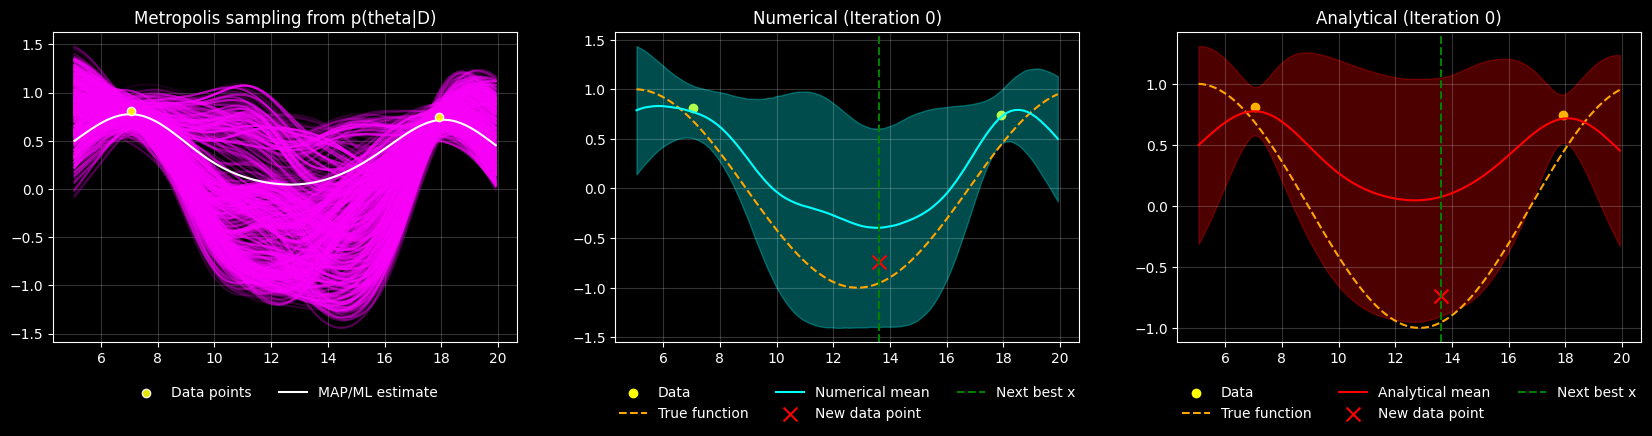

Time used for iteration #0: 87.9539 seconds

Metropolis acceptance rate: 0.26


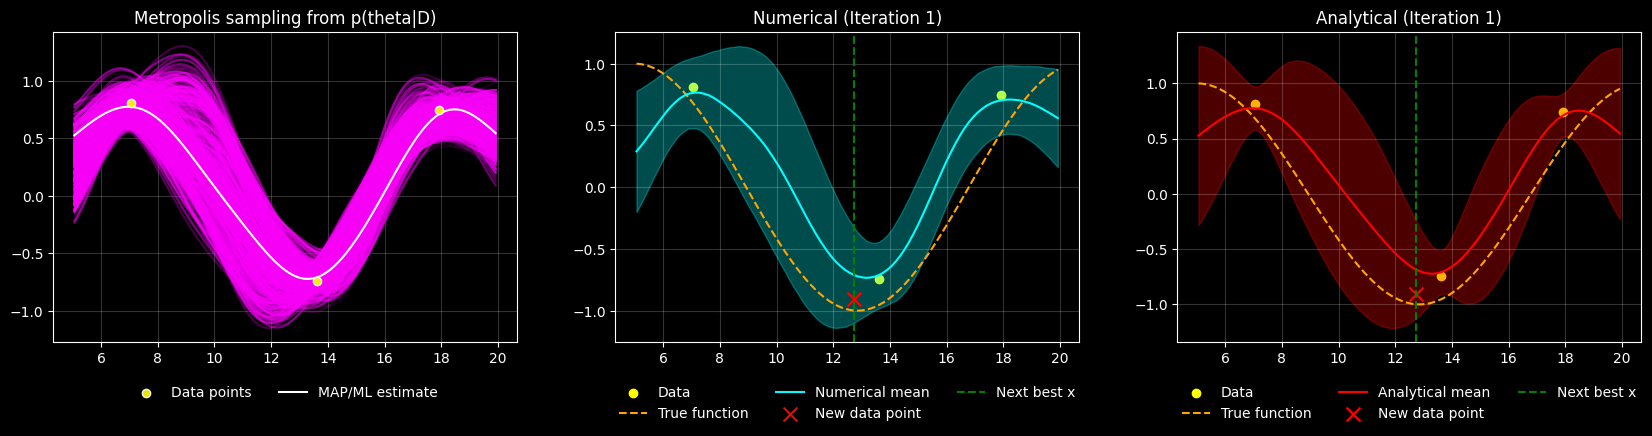

Time used for iteration #1: 58.0682 seconds

Metropolis acceptance rate: 0.25


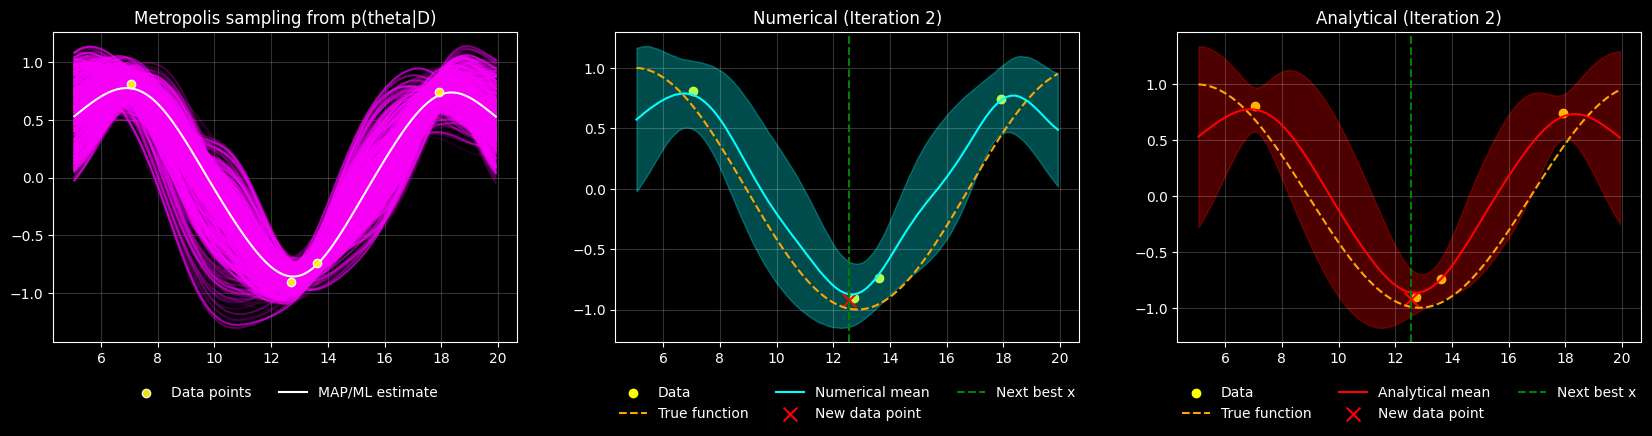

Time used for iteration #2: 56.9494 seconds

Metropolis acceptance rate: 0.23


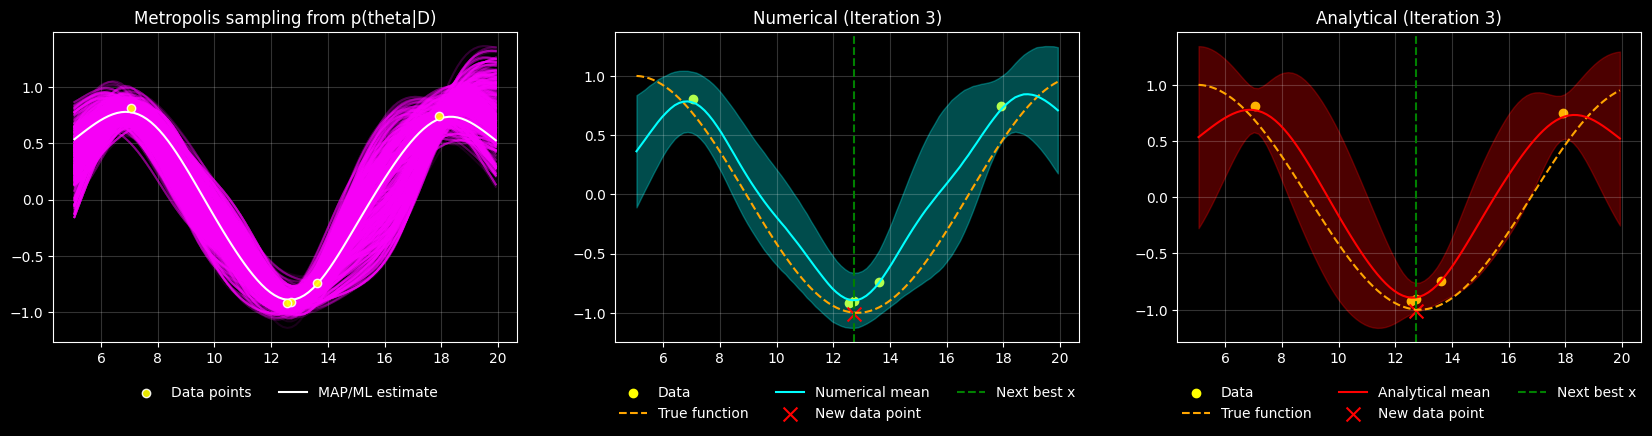

Time used for iteration #3: 56.4128 seconds

Metropolis acceptance rate: 0.23


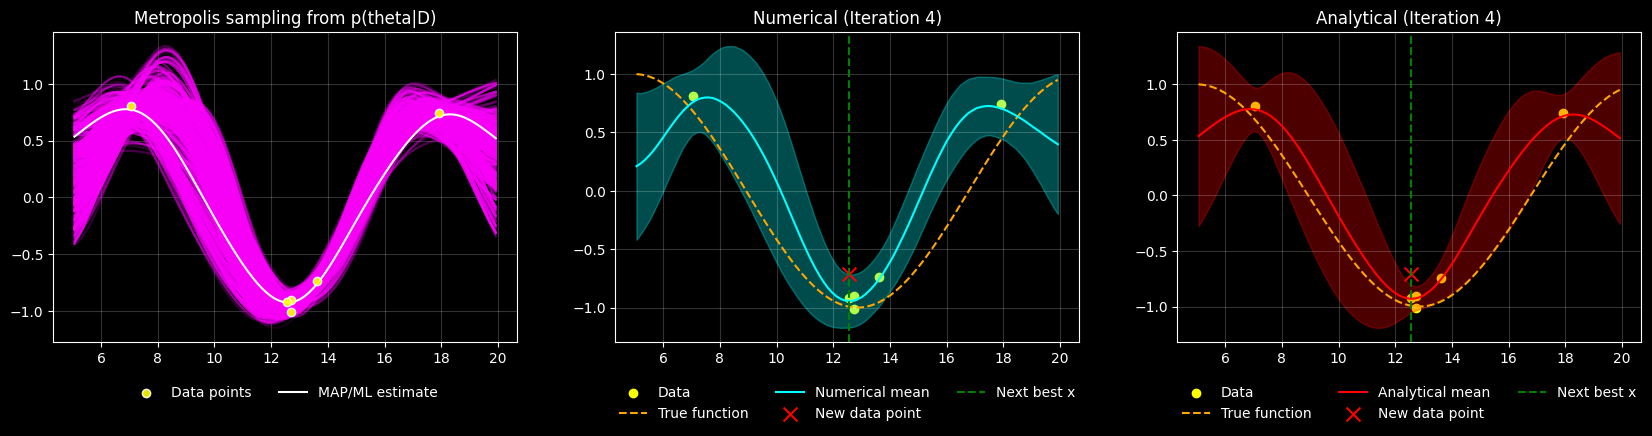

Time used for iteration #4: 58.0658 seconds

Metropolis acceptance rate: 0.23


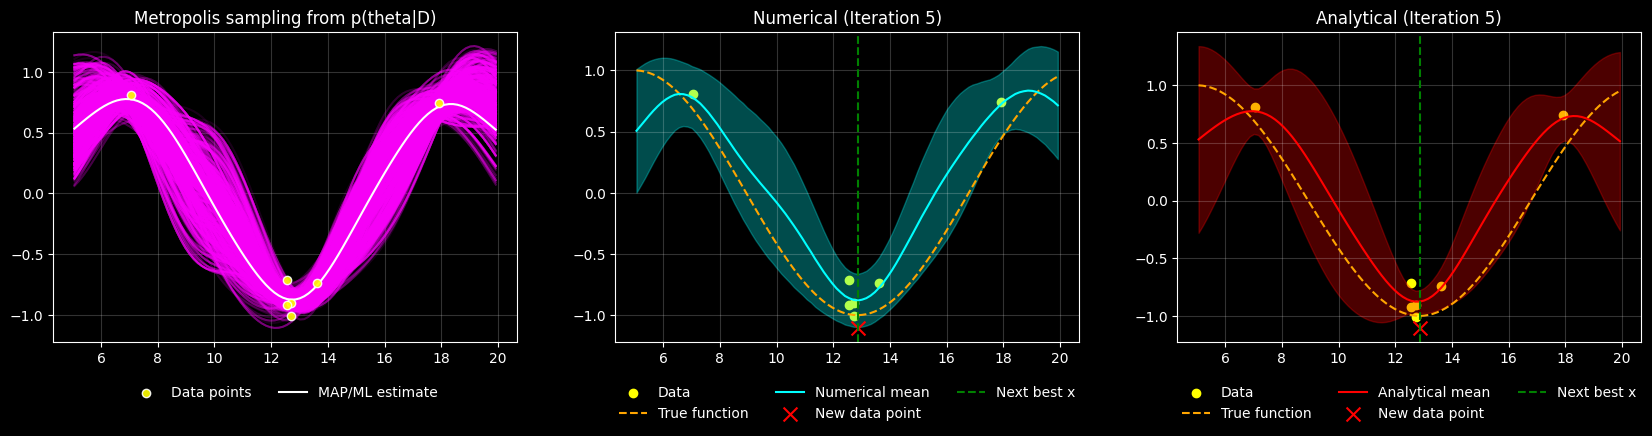

Time used for iteration #5: 57.6246 seconds

Metropolis acceptance rate: 0.22


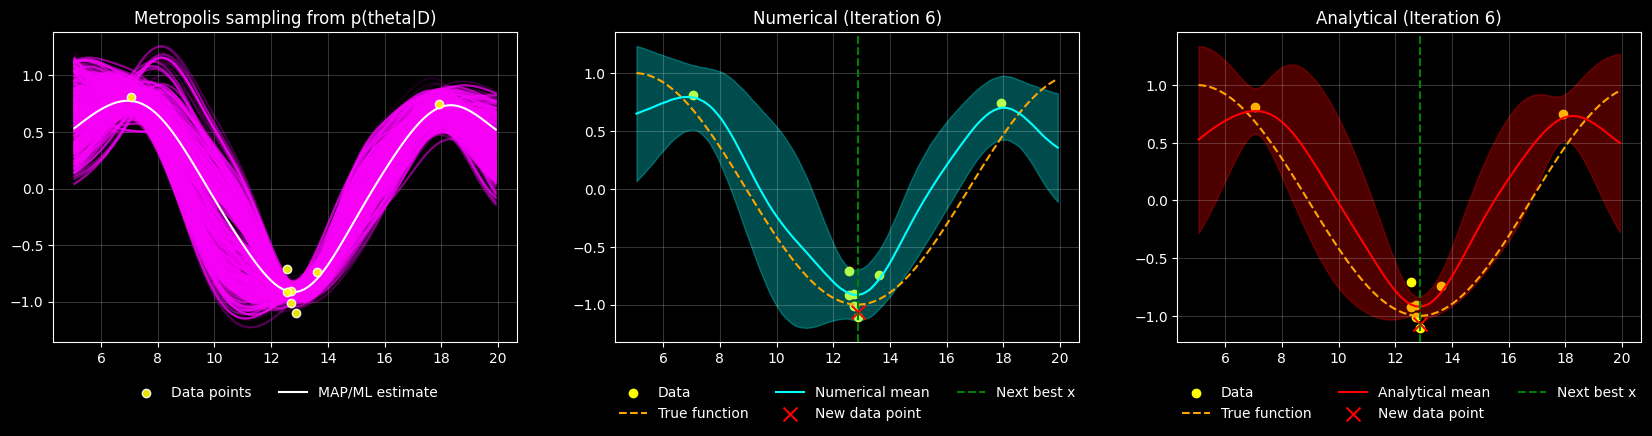

Time used for iteration #6: 58.2653 seconds

Metropolis acceptance rate: 0.18


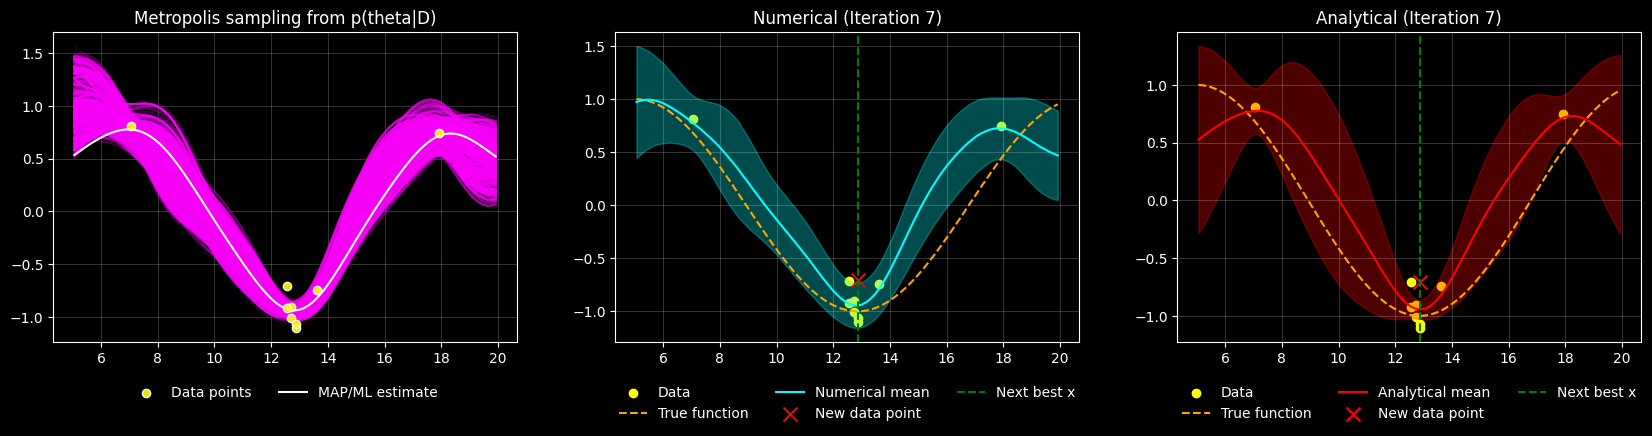

Time used for iteration #7: 55.7852 seconds

Metropolis acceptance rate: 0.20


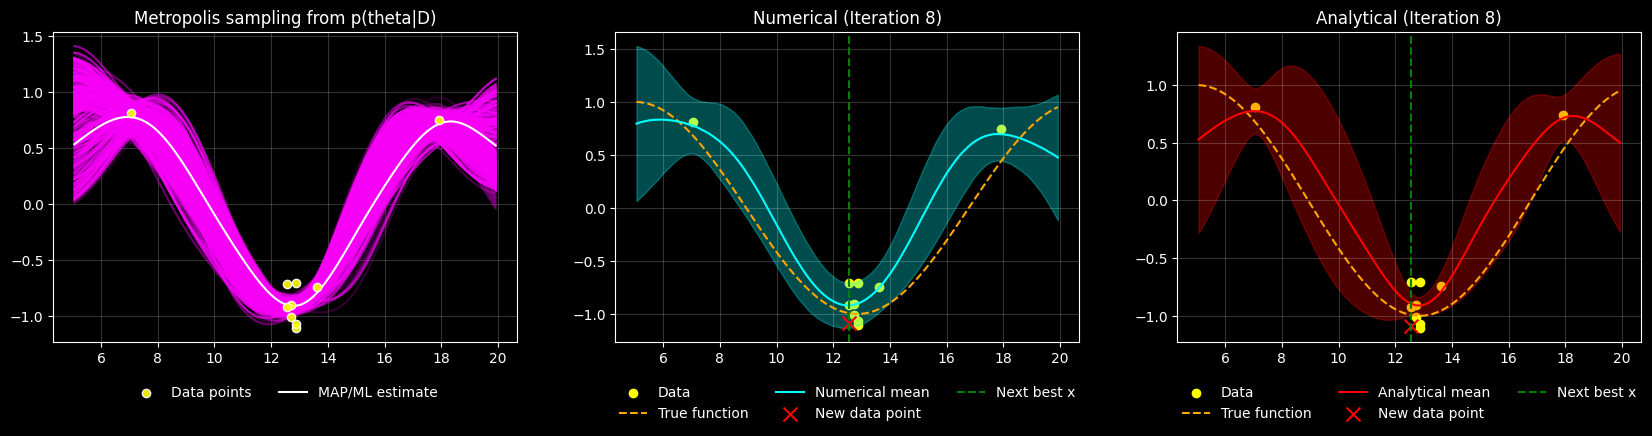

Time used for iteration #8: 62.3745 seconds

Metropolis acceptance rate: 0.19


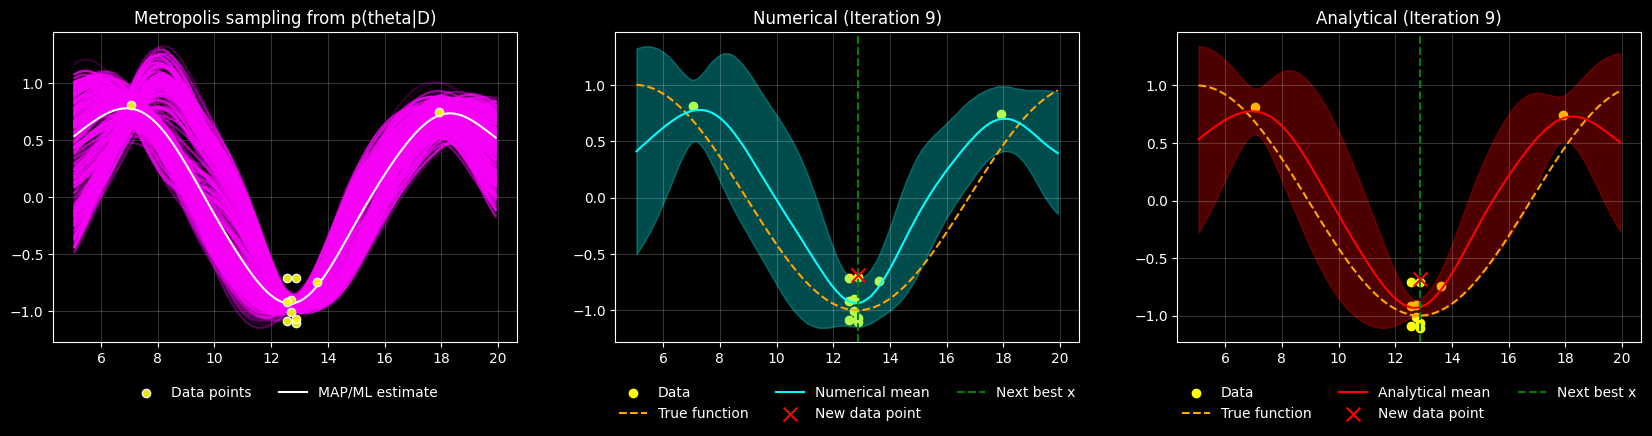

Time used for iteration #9: 57.0158 seconds



In [ ]:
kernel_reg = BayesianKernelRegression(
    num_points=2,
    num_x_test=100,
    num_rff_features=300,
    num_mc=10,
    metropolis_step_size=3e-3,
    num_samples_metropolis=2000,
    burn_in=200,
    num_gd_iter=10000,
    debug=False
    )

# Bayesian optimization
kernel_reg.main_bo_lcb(max_iterations=10, convergence_threshold=None)